In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_classification, load_wine, load_breast_cancer, load_diabetes, load_digits

In [2]:
plt.style.use('seaborn-darkgrid')

In [3]:
def plot_scatter(x, y, auto_scaled=True, title=None, clusters=None):
    plt.figure(figsize=(4, 4))
    plt.scatter(x, y, c=clusters, cmap='bwr')
    
    if not auto_scaled:
        plt.axis('square')
    
    plt.grid(True)
    plt.title(title)
    
    plt.show()
    
def return_X_y(data, target_column):
    return data.drop(target_column, axis=1), data[target_column]

In [4]:
wine_sklearn = load_wine(as_frame=True)
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

In [5]:
import warnings
warnings.filterwarnings("ignore")

# Homework

## Exercise  1 - Scaling (2 points)

Perform standardization for wine dataset (`wine_data`) using only basic python, numpy and pandas (without using `StandardScaler` and sklearn at all). Implementation of function (or class) that can get dataset as input and return standardized dataset as output is preferrable, but not necessary.

Compare you results (output) with `StandardScaler`.

**NOTE:**

- 1 point for functional version, 2 points for implementing scaling as sklearn pipeline compartible class. 
- Maximum for the exercise is 2 points.


### Simple version (1 point)

In [6]:
# 1 point
def scale(X):
    for column in X:
        X[column] = (X[column] - X[column].mean())/X[column].std(ddof=0)
    return X

In [7]:
assert np.allclose(np.array(scale(wine_data)), StandardScaler().fit_transform(wine_data))

### Pipeline Version (2 points)

In [8]:
wine_data.mean()

alcohol                         7.841418e-15
malic_acid                      2.444986e-16
ash                            -4.059175e-15
alcalinity_of_ash              -7.110417e-17
magnesium                      -2.494883e-17
total_phenols                  -1.955365e-16
flavanoids                      9.443133e-16
nonflavanoid_phenols           -4.178929e-16
proanthocyanins                -1.540590e-15
color_intensity                -4.129032e-16
hue                             1.398382e-15
od280/od315_of_diluted_wines    2.126888e-15
proline                        -6.985673e-17
dtype: float64

In [9]:
# 2 points
from sklearn.base import BaseEstimator, TransformerMixin
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, copy=True, with_mean=True, with_std=True):
        self.copy = copy
        self.with_mean = with_mean
        self.with_std = with_std

    def fit(self, X, y=None):
        self.mean = X.mean()
        self.std = X.std(ddof=0)
        return self

    def transform(self, X, y=None, copy=None):
        if self.copy:
            X = X.copy()
        if self.with_mean and self.with_std:
            X = (X - self.mean)/self.std
        elif self.with_mean:
            X = (x - self.mean)
        elif self.with_std:
            X = (X)/self.std
        return X

In [10]:
assert np.allclose(CustomScaler().fit_transform(wine_data), StandardScaler().fit_transform(wine_data))

__**I implemented both the function and the class**__

## Exercise  2 - Visualization (3 points)

As noted earlier, standardization/normalization of data can be crucial for some distance-based ML methods.

Let’s generate some toy example of unnormalized data and visualize the importance of this process once more:

In [11]:
feature_0 = np.random.randn(1000) * 10   
feature_1 = np.concatenate([np.random.randn(500), np.random.randn(500) + 5])
data = np.column_stack([feature_0, feature_1])
data 

array([[ 7.50389704e+00, -1.24838385e-02],
       [ 7.77395408e+00,  5.19170159e-01],
       [-1.57403340e+01, -1.87148631e-01],
       ...,
       [ 2.91402725e+00,  4.64158100e+00],
       [ 1.19287280e+01,  5.77311803e+00],
       [-5.43660921e+00,  4.42502533e+00]])

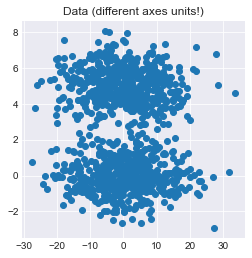

In [12]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=True, title='Data (different axes units!)')

**NOTE:** on the plot above axes are scaled differently and we can clearly see two potential *classes/clusters*. In fact `matplotlib` performed `autoscaling` (which is basically can be considered as `MinMaxScaling` of original data) just for better visualization purposes.

Let's turn this feature off and visualize the original data on the plot with equally scaled axes:

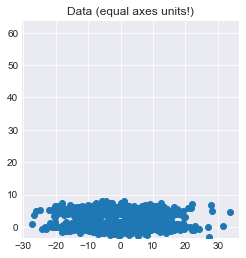

In [13]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False , title='Data (equal axes units!)')

This picture is clearly less interpretable, but much closer to "how distance-based algorithm see the original data": separability of data is hardly noticable only because the variation (std) of x-feature is much bigger in absolute numbers.

Perform `StandardScaling` and `MinMaxScaling` of original data; visualize results for each case (**use `plot_scatter` with `auto_scaled=False`**):

### MinMaxScaling (0.5 point)

__**Results after MinMaxScaling are visualized below**__

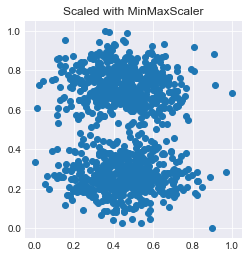

In [14]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)
plot_scatter(scaled[:, 0], scaled[:, 1], auto_scaled=False , title='Scaled with MinMaxScaler')

### StandardScaler (0.5 point)

__**Results after StandardScaler are visualized below**__

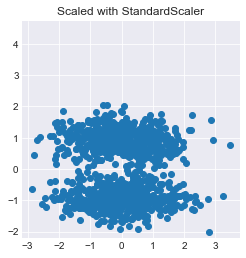

In [15]:
scaler = StandardScaler()
scaled = scaler.fit_transform(data)
plot_scatter(scaled[:, 0], scaled[:, 1], auto_scaled=False , title='Scaled with StandardScaler')

### (Bonus) K-means (2 points)

Illustrate the impact of scaling on basic distance-based clustering algorithm [K-means](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1) using `data` generated above.

**NOTE:** basically, you don't need understanding K-means algorithm here, you just need to:

1) run algorithm (with k=2, k - number of clusters/classes) on unscaled data    
2) run algorithm (with k=2) on scaled data    
3) plot results: highlight different clusters using different colors.

You can use this [question](https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering/89813) as a hint, but I recommend you to plot results using `plot_scatter` with `equal_scaled=True`: it might help you to intuitively understand the reasons of such scaling impact.


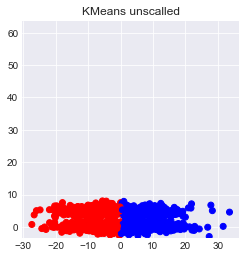

In [16]:
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=2)
clusters = Kmean.fit_predict(data)
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False, clusters=clusters, title='KMeans unscalled')

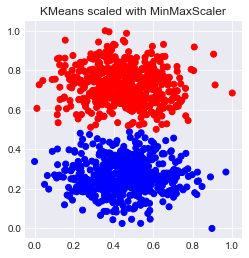

In [17]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)
clusters = Kmean.fit_predict(scaled)
plot_scatter(scaled[:, 0], scaled[:, 1], auto_scaled=False, clusters=clusters, title='KMeans scaled with MinMaxScaler')

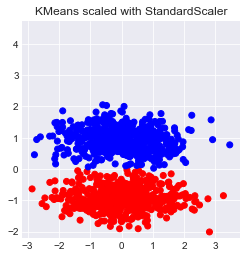

In [18]:
scaler = StandardScaler()
scaled = scaler.fit_transform(data)
clusters = Kmean.fit_predict(scaled)
plot_scatter(scaled[:, 0], scaled[:, 1], auto_scaled=False, clusters=clusters, title='KMeans scaled with StandardScaler')

__**As seen above, after scaling the data can be clearly separated in 2 clusters**__

## Exercise  3 - Preprocessing Pipeline (2 points)

In [19]:
wine_sklearn = load_wine(as_frame=True)
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

In [20]:
wine_train, wine_val, wine_labels_train, wine_labels_val = train_test_split(wine_data, wine_labels, 
                                                                            test_size=0.3, random_state=42)

Train model (for example, `LogisticRegression(solver='liblinear', penalty='l1')` on raw `wine_train` data; then train same model after data scaling; then add feature selection (and train model again on scaled data). For each experiment all required preprocessing steps (if any) should be wrapped into sklearn pipeline.

Measure `accuracy` of all 3 approaches on `wine_val` dataset. Describe and explain results.

__**Pipeline with model trained on raw data**__

In [21]:
model = LogisticRegression(solver='liblinear', penalty='l1')
score = model.fit(wine_train, wine_labels_train).predict(wine_val)
accuracy_score(score, wine_labels_val)

0.9814814814814815

__**Pipeline with model trained on Scaled data**__

In [22]:
model = LogisticRegression(solver='liblinear', penalty='l1')
pipeline = Pipeline([('scaler', StandardScaler())])
model.fit(pipeline.fit_transform(wine_train), wine_labels_train)
accuracy_score(model.predict(pipeline.transform(wine_val)), wine_labels_val)

0.9814814814814815

__**Pipeline with model trained on Scaled data with Feature selection (SequentionalFeatureSelector) with default n_features to select**__

In [23]:
model = LogisticRegression(solver='liblinear', penalty='l1')
pipeline = Pipeline([('feature_selector', SequentialFeatureSelector(model, scoring='accuracy')), ('scaler', StandardScaler())])
model.fit(pipeline.fit_transform(wine_train, wine_labels_train), wine_labels_train)
accuracy_score(model.predict(pipeline.transform(wine_val)), wine_labels_val)

0.9074074074074074

__**Pipeline with model trained on Scaled data with Feature selection (SequentionalFeatureSelector) with 10 n_features to select**__

In [24]:
model = LogisticRegression(solver='liblinear', penalty='l1')
pipeline = Pipeline([('feature_selector', SequentialFeatureSelector(model, scoring='accuracy', n_features_to_select=10)), ('scaler', StandardScaler())])
model.fit(pipeline.fit_transform(wine_train, wine_labels_train), wine_labels_train)
accuracy_score(model.predict(pipeline.transform(wine_val)), wine_labels_val)

1.0

__**Pipeline with model trained on Scaled data with Feature selection (SelectFromModel)**__

In [25]:
model = LogisticRegression(solver='liblinear', penalty='l1')
pipeline = Pipeline([('feature_selector', SelectFromModel(model)), ('scaler', StandardScaler())])
model.fit(pipeline.fit_transform(wine_train, wine_labels_train), wine_labels_train)
accuracy_score(model.predict(pipeline.transform(wine_val)), wine_labels_val)

1.0

__**About results**__

To underlime, the accuracy score for raw data is 0.9814814814814815 which is quite high. May be that's due to the particular test_train split that we have or just because of the dataset. As we can see above, our accuracy score for raw data (0.9814814814814815) and scaled data (0.9814814814814815) is the same. It might be due to an accident. Maybe train_testsplit's random_state could work that way that that our scaled data doesn't make any difference (below I actually prove my point that random_state matters) or just or dataset is too small. I believe that if we used scalling on another dataset, it would make a difference, otherwise people would not use scaling at all.

As for the difference between scaled data and scaled data with feature selector, I used SequentionalFeatureSelector and SelectFromModel.

1. With SequentialFeatureSelector, if we take n_feaetures_to_select parameter as default - accuracy will decrease on the dataset (0.9074074074074074). By researching how SequentialFeatureSelector works, I found that by default it has a forward direction (as in our case) meaning that it adds features that improve our model. However, if n_features_to_select parametes is default, then it takes half of all features and this amount considering that we have only 13 features might be not enough to have a better accuracy than when we have no feature selector. Later, I use SequentialFeatureSelector with n_features_to_select equals 10 and it improves our model (it has 1.0 accuracy), so I believe my thought that I wrote before might be rights.

2. With SelectFromModel we have improved results of our model (we have 1.0 accuracy). This improvement without changing any arguments of the feature selector like threshold or max_features might be just an accident. I believe if we took another dataset, we would have to set arguments like we did with SequentialFeatureSelector to achieve such a high accuracy.

Overall, I can say about Feature Selectors that they improved the accuracy of the model as they were supposed to because Feature selectors are used to either improve estimators’ accuracy scores or to boost their performance on very high-dimensional datasets. In our case, Feature Selecors just found among 13 features the ones that improve accuracy and do not improve it and left the optimal features that maximize our accuracy.

__**To prove my point that Scaling did NOT improve model accuracy either because of the dataset itself or random_state in test_train_split, I will change random_state to 50 and try to train the model again**__

In [26]:
wine_sklearn = load_wine(as_frame=True)
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

In [27]:
wine_train, wine_val, wine_labels_train, wine_labels_val = train_test_split(wine_data, wine_labels, 
                                                                            test_size=0.3, random_state=50)

__**Pipeline with model trained on raw data with CHANGED RANDOM STATE**__

In [28]:
model = LogisticRegression(solver='liblinear', penalty='l1')
score = model.fit(wine_train, wine_labels_train).predict(wine_val)
accuracy_score(score, wine_labels_val)

0.9629629629629629

__**Pipeline with model trained on Scaled data with CHANGED RANDOM STATE**__

In [29]:
model = LogisticRegression(solver='liblinear', penalty='l1')
pipeline = Pipeline([('scaler', StandardScaler())])
model.fit(pipeline.fit_transform(wine_train), wine_labels_train)
accuracy_score(model.predict(pipeline.transform(wine_val)), wine_labels_val)

1.0

As you can see above, both accuracy on raw data and scaled data improved with changed to 50 random_state because random_state influences how data gets split into train and test. But the main point is that now accuracy on scaled data is better than accuracy on raw data, so model's behaviour with random_state = 42 is just abnormal and doesn't mean that scaling doesn't matter. As I have proven it depends on a situation.

## Exercise 4 - manual PCA (5 points)
The task is to solve PCA as an optimization problem, without explicitly doing eigen value decomposition.
In the most general setting PCA is minimization of reconstruction error of a projection of given rank $q$

$$\min_{\mu, \lambda_1,\ldots, \lambda_n, \mathbf{V}_q} \sum_{i=1}^n ||x_i - \mu - \mathbf{V}_q \lambda_i||^2$$

With a number of steps that can be found here https://stats.stackexchange.com/a/10260 this task transforms to
 $$\max_{u_i} \sum_{i=1}^q u_i^T \mathbf{S} u_i$$
 where $\mathbf{S}$ is the sample covariance matrix (after standartization) and $u_1, \ldots, u_q$ are the $q$ are orthonormal columns in $\mathbf{V}_q$.
 Let us solve this optimization problem with `scipy.optimize` library.
 
 Additional 2 point are given for visualization of the results.

### PCA (3 points)

In [30]:
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

Find a covariance matrix of standartized data and assing it to S.

In [31]:
scaler = StandardScaler()
scaled_wine_data = scaler.fit_transform(wine_data)
S =np.dot(scaled_wine_data.T, scaled_wine_data) / (scaled_wine_data.shape[0] - 1)

If your code is correct, the following assert should be Ok.

In [32]:
assert np.allclose(np.linalg.norm(S), 5.787241159764733)

In [33]:
from scipy.optimize import minimize

def objective(x):
    return -(x.T @ S @ x)

def norm_constraint(x):
    # your code: constaraint norm of x to be 1, function should return 0 if constraint holds
    return 1 - x.T @ x

# we could implement the thing above like
#     if np.linalg.norm(x) == 1:
#         return 0
#     else:
#         return 1 - x.T @ x
# but it is the same thing as I wrote, so I chose a more consice version

con1 = {'type': 'eq', 'fun': norm_constraint}

x0 = np.zeros(wine_data.shape[1])

sol = minimize(objective, 
               x0, 
               constraints = [con1]
              )
x0 = sol.x

__**To underline in norm_constraint function we could use**__

In [34]:
#if np.linalg.norm(x) == 1:
#         return 0
#     else:
#         return 1 - x.T @ x

__**but it is identical to what I wrote**__

Hurray! We have first vector! Let's do another one.

In [35]:
def orthogonality_constraint(x):
    return x.T @ x0

# here we could also do like
# if x.T @ x0 == 0:
#         return 0
#     else:
#         return -(x.T @ x0)
# but it is the same as I wrote above

con2 = {'type': 'eq', 'fun': orthogonality_constraint}

x1 = np.zeros(wine_data.shape[1])


sol = minimize(objective, 
               x1, 
               constraints = [con1, con2]
              )

x1 = sol.x

__**To underline in orthogonality_constraint function we could use**__

In [36]:
#if x.T @ x0 == 0:
#         return 0
#     else:
#         return -(x.T @ x0)

__**but it is identical to the approach I chose**__

If your solution is correct, the following asserts should be Ok.

In [37]:
assert np.allclose(x0@S@x0, 4.732436977583595)
assert np.allclose(x1@S@x1, 2.5110809296451233)

### Visualization (2 points)

Visualize the points after applying custom dimension reduction with 2 components.

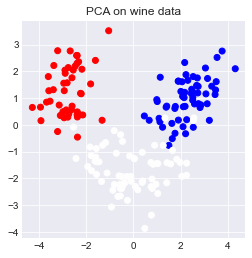

In [38]:
plot_scatter((scaled_wine_data @ x0), (scaled_wine_data @ x1), auto_scaled=True, clusters=wine_labels, title='PCA on wine data')

__**As seen above now we have 3 clear clusters of data**__

I will provide the same visualization but on a bigger scale.

In [39]:
dataframe = pd.DataFrame({'PC1': (scaled_wine_data @ x0), 'PC2': (scaled_wine_data @ x1), 'Y': wine_labels})

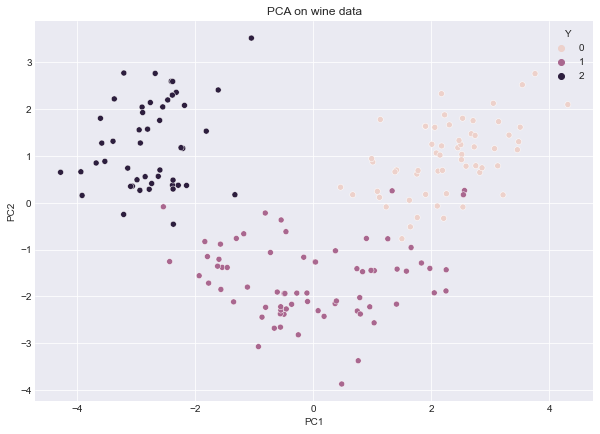

In [40]:
plt.figure(figsize=(10, 7))
plt.title('PCA on wine data')
plt.ylabel('PC2')
plt.xlabel('PC1')
sns.scatterplot(x='PC1', y='PC2', hue='Y', data=dataframe)
plt.show()

__**What we had before using PCA is seen below**__

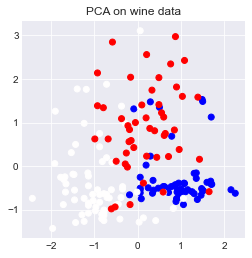

In [41]:
plot_scatter(scaled_wine_data[:, 0], scaled_wine_data[:, 1], auto_scaled=True, clusters=wine_labels, title='PCA on wine data')

As we can see it is difficult to find a difference between classes without PCA.

## Exercise 5 - Boruta (3 points)

Let us classify handwritten digits 0, 1 and 2. 
To make task not so easy the images are binarized (no shadows of gray present) as it happens with xerocopied documents.

Let us also find out to which parts of an image there's no need to look in order to clasify three digits of interest.

In [42]:
X, y = load_digits(n_class=3, return_X_y=True, as_frame=True)
X = (X>10).astype(int)

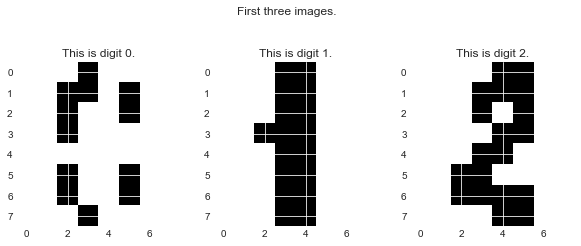

In [43]:
f, ax = plt.subplots(1,3,figsize=(10,4))
for i in range(3):
    ax[i].imshow(X.iloc[i].values.reshape(8,8))
    ax[i].set_title(f"This is digit {y[i]}.")
plt.suptitle("First three images.")
plt.show()

Split data into train and test, let test size be 30% of the dataset and fix random state to 42:

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [45]:
assert y_val.shape[0] == 162
assert y_val.sum() == 169

Fit a RandomForestClassifier with max_depth=13 and evaluate it's performance:

In [46]:
clf = RandomForestClassifier(max_depth=13, random_state=42)

clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_val)
acc = accuracy_score(y_val, y_pred_test)
print(acc)

0.9938271604938271


In [47]:
assert acc > 0.98

Now we will use Boruta to find redundand pixels. If the package is not installed in your system, uncomment and run the following cell.

__**I have conda, so I used**__

In [48]:
# conda install -c conda-forge boruta_py

In [49]:
from boruta import BorutaPy

feat_selector = BorutaPy(RandomForestClassifier(max_depth=13), 
                         n_estimators='auto', 
                         verbose=0, 
                         max_iter=100,
                         random_state=42)

feat_selector.fit(np.array(X_train), np.array(y_train))

BorutaPy(estimator=RandomForestClassifier(max_depth=13, n_estimators=62,
                                          random_state=RandomState(MT19937) at 0x1CAA9500040),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1CAA9500040)

Let us print redundant pixels as a mask. Does the result looks similar to mine (or to Among us chracters)? 

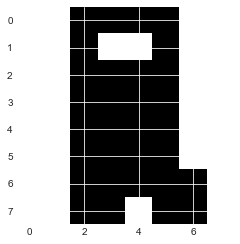

In [50]:
mask = np.array(feat_selector.support_).reshape(8,8)
plt.imshow(mask);

At the end let us redo  classification but only with selected features

In [51]:
clf = RandomForestClassifier(max_depth=13, random_state=42)

X_filtered = feat_selector.transform(np.array(X_train))
X_filtered_val = feat_selector.transform(np.array(X_val))

clf.fit(X_filtered, y_train)
y_pred_test_boruta = clf.predict(X_filtered_val)
acc = accuracy_score(y_val, y_pred_test_boruta)
print(acc)

0.9938271604938271


__**As we can see below, boruta indeed changes the shape of the dataset.**__

In [52]:
X_train.shape

(375, 64)

In [53]:
X_filtered.shape

(375, 31)

In [54]:
assert acc > 0.99

__**Interesting but before and after using Boruta we have the same accuracy. May be it has something to do with random_seed or just this dataset**__

# Materials & References

1. General article about feature engineering and selection (main reference):
https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_english/topic06_features_regression/topic6_feature_engineering_feature_selection.ipynb

2. Feature engineering/preprocessing, using scikit-learn API (great code examples, but really brief explanation):    
https://scikit-learn.org/stable/modules/preprocessing

3. Feature scaling/normalization:     
https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35

4. Log Transform/power transform:    
https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9

6. Missing values preprocessing using scikit-learn API (great code examples, great explanation):    
https://scikit-learn.org/stable/modules/impute.html

7. Feature selection scikit-learn API (great code examples, great explanation):   
https://scikit-learn.org/stable/modules/feature_selection.html

8. Melbourne housing dataset source:    
https://www.kaggle.com/anthonypino/melbourne-housing-market